**Convolutional Networks with Residual Blocks**

# Residual Network Models

Checked 1/20/2023

The idea behind a Residual Network (RESNET) is that we "skip" around layers,  which allows training information (the gradient) to more easily
reach the initial layers of a network

Suppose we want to predict some function H(x)

We might initially just say that H(x)= x,    which is not a great prediction, but we could then compute the residuals

     R(x)= H(x)-x

and then rearrange this to read

     H(x) = x + R(x)
     
Thus to build a model H(x),   we could carry this out by estimating x and R(x),   where R(x) is perhaps easier to estimate.

If we have a first layer of neurons that gives use f(x), where x is the input data and a second layer than gives us

    R(f(x)) =H(x)-f(x)
    
    H(x) =R(f(x)) + f(x)
  
The advantage of this way of stating what H((x) is the fact that the linearity of this model makes it easier to back propagate to f(x), then if we just used

    H(x) = G(f(x))
    
The skipping or residual concept really first appeared in working with Convolutional networks,  to incoporate information from finer spatial skills (the lowest level filters),  but the residual concept works in all types of models.


Here is an example using the MNIST data set yet again

In [1]:
import tensorflow as tf

from tensorflow.keras.datasets import fashion_mnist

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [2]:
X_train_full.shape

(60000, 28, 28)

In [3]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

In [4]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [6]:
from tensorflow import keras

modelc = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same",
                        input_shape=[28, 28,1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

The first model to look at is just a CNN with no skipping or residuals

In [7]:
modelc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 256)        0

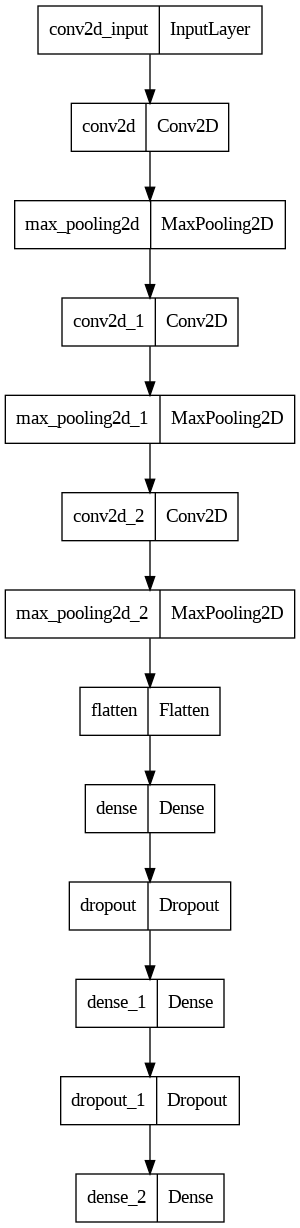

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(modelc)

In [9]:
modelc.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

We can time the training process

In [10]:
import time

In [11]:
t=time.time()
historyc = modelc.fit(X_train, y_train, epochs=10,batch_size=256,validation_data=(X_valid, y_valid))
elapsed=time.time()-t
print(elapsed)

Epoch 1/10
215/215 [==============================] - 17s 20ms/step - loss: 1.0088 - accuracy: 0.6368 - val_loss: 0.4419 - val_accuracy: 0.8434
Epoch 2/10
215/215 [==============================] - 3s 15ms/step - loss: 0.5471 - accuracy: 0.8096 - val_loss: 0.3385 - val_accuracy: 0.8724
Epoch 3/10
215/215 [==============================] - 3s 15ms/step - loss: 0.4518 - accuracy: 0.8481 - val_loss: 0.3152 - val_accuracy: 0.8852
Epoch 4/10
215/215 [==============================] - 3s 16ms/step - loss: 0.3992 - accuracy: 0.8658 - val_loss: 0.2885 - val_accuracy: 0.8928
Epoch 5/10
215/215 [==============================] - 3s 15ms/step - loss: 0.3565 - accuracy: 0.8811 - val_loss: 0.2654 - val_accuracy: 0.8984
Epoch 6/10
215/215 [==============================] - 3s 15ms/step - loss: 0.3315 - accuracy: 0.8889 - val_loss: 0.2444 - val_accuracy: 0.9096
Epoch 7/10
215/215 [==============================] - 3s 15ms/step - loss: 0.3030 - accuracy: 0.8979 - val_loss: 0.2436 - val_accuracy: 0.907

**Pseudo Code for a residual bloc**k

x=...                                     # input x

residual = x

x=block_operation(x)

x=add([x,residual])

**Implementing a Residual Block**

This is a model based on input x, where x will be a  32 x 32 x 3 image

We have a rescaling layer built into the model

Then we define a residual_block layer,  a custom created layer

It implements two layers of convolution, followed by a pooling layer if desired, and then the residuals are added.   Note that if the pooling is used
the input is processed with a single convolutional filter with stride set at 2 to reduce the input data (X) to the same dimension as the pooled data

In [12]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1))
x = layers.Rescaling(1./255)(inputs)
  
def residual_block(x, filters, pooling=False):                            
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)         
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)                    
    x = layers.add([x, residual])
    return x
  
x = residual_block(x, filters=32, pooling=True)                           
x = residual_block(x, filters=64, pooling=True)                           
x = residual_block(x, filters=128, pooling=False)                         
 
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="sigmoid")(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 28, 28, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 32)   320         ['rescaling[0][0]']              
                                                                                                  
 conv2d_4 (Conv2D)              (None, 28, 28, 32)   9248        ['conv2d_3[0][0]']               
                                                                                              

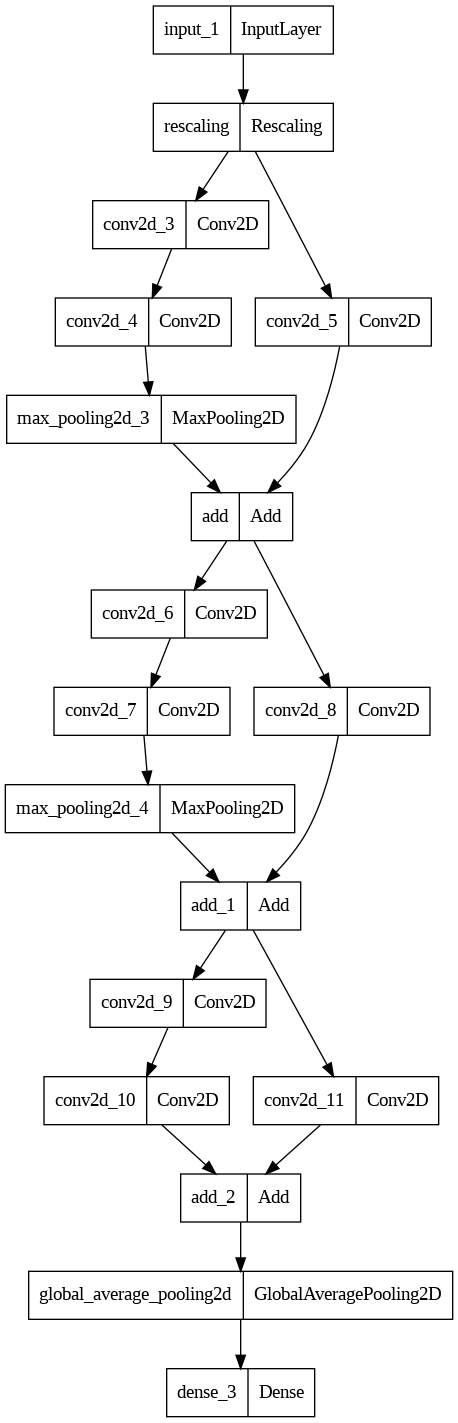

In [13]:
plot_model(model2)

In [14]:
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [15]:
# seems to need about 20 epochs, so a tad slow

t=time.time()
history2 = model2.fit(X_train, y_train, epochs=20,batch_size=128,validation_data=(X_valid, y_valid))
elapsed=time.time()-t
print(elapsed)

Epoch 1/20
430/430 [==============================] - 10s 13ms/step - loss: 1.6395 - accuracy: 0.3780 - val_loss: 0.8419 - val_accuracy: 0.6928
Epoch 2/20
430/430 [==============================] - 5s 11ms/step - loss: 0.7910 - accuracy: 0.7008 - val_loss: 0.7133 - val_accuracy: 0.7260
Epoch 3/20
430/430 [==============================] - 5s 11ms/step - loss: 0.6929 - accuracy: 0.7327 - val_loss: 0.6215 - val_accuracy: 0.7656
Epoch 4/20
430/430 [==============================] - 5s 12ms/step - loss: 0.6348 - accuracy: 0.7549 - val_loss: 0.6127 - val_accuracy: 0.7702
Epoch 5/20
430/430 [==============================] - 5s 11ms/step - loss: 0.5853 - accuracy: 0.7781 - val_loss: 0.5708 - val_accuracy: 0.7920
Epoch 6/20
430/430 [==============================] - 5s 12ms/step - loss: 0.5505 - accuracy: 0.7919 - val_loss: 0.5209 - val_accuracy: 0.8086
Epoch 7/20
430/430 [==============================] - 5s 12ms/step - loss: 0.5155 - accuracy: 0.8072 - val_loss: 0.5007 - val_accuracy: 0.820

**Batch normalization**

When we use a standard scaler on our input data, it limits the range of the data, so that it has a mean of 0 and a standard deviation of 1

It seems to help to standardize data in between layers in a very deep neural
net,  the reason for this is a bit unclear.  It is not an expensive operation to run, and it does appear to make training the model faster.   

We do want to normalize *before* the activation function

The wrong approach:

     x = layers.Conv2D(32, 3, activation="relu")(x)
     x = layers.BatchNormalization()(x)

the right approach:

    x = layers.Conv2D(32, 3, use_bias=False)(x)    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x) 

Convolution layers have a bias,  turn this off

**CNN with residuals and batch normalization**

In [16]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Rescaling(1./255)(inputs)
  
def residual_block(x, filters, pooling=False):                            
    residual = x
    x = layers.Conv2D(filters, 3, use_bias=False, padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)         
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)                    
    x = layers.add([x, residual])
    return x
  
x = residual_block(x, filters=32, pooling=True)                           
x = residual_block(x, filters=64, pooling=True)                           
x = residual_block(x, filters=128, pooling=False)                         
 
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(10, activation="sigmoid")(x)
model2b = keras.Model(inputs=inputs, outputs=outputs)
model2b.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 28, 28, 1)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 28, 28, 32)   288         ['rescaling_1[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 32)  128         ['conv2d_12[0][0]']              
 alization)                                                                                 

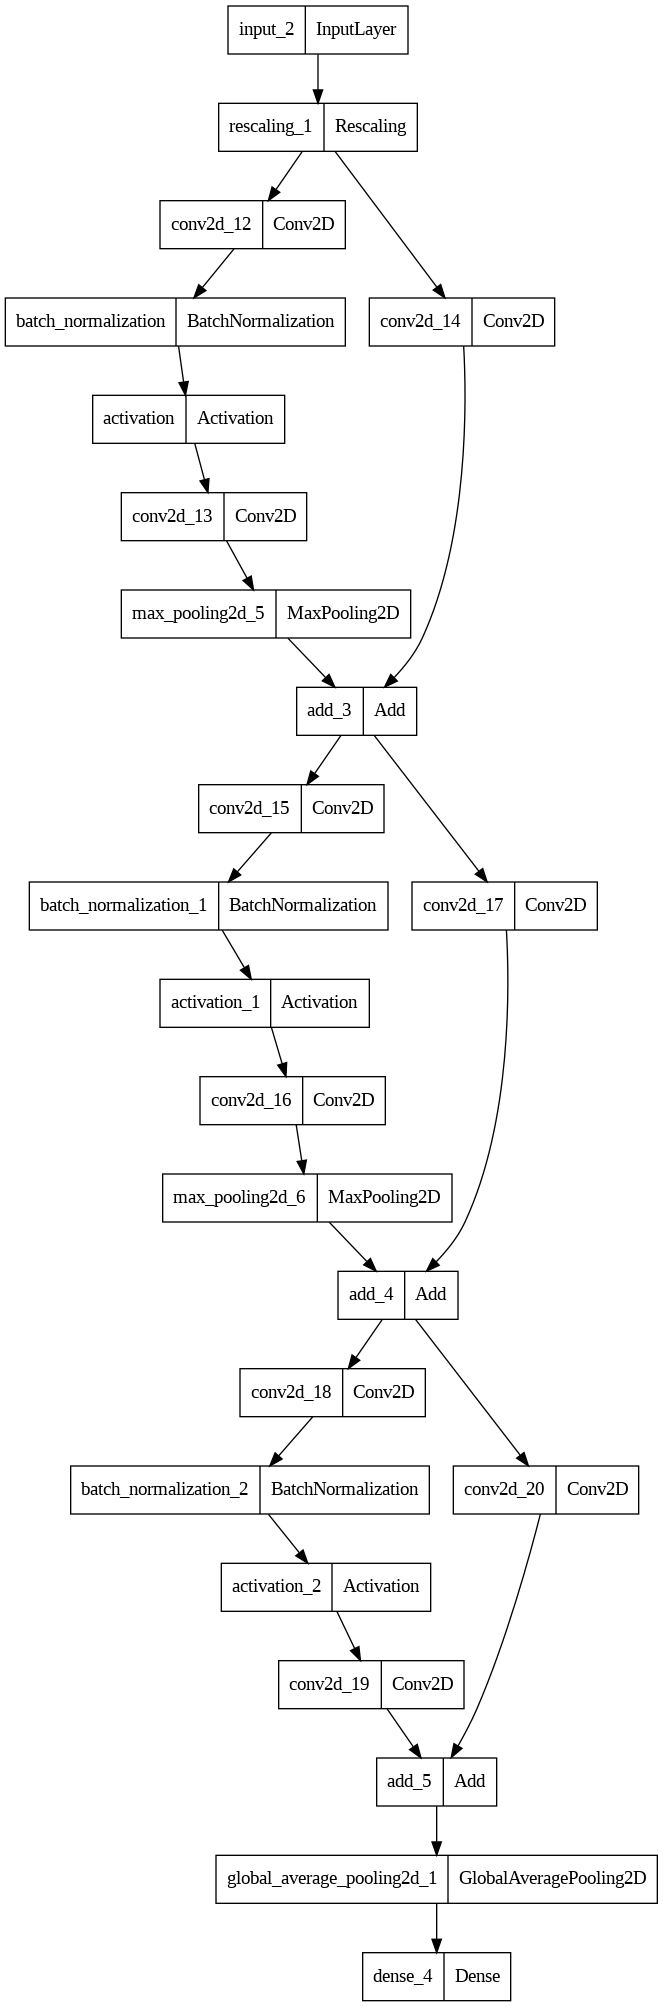

In [17]:
plot_model(model2b)

In [18]:
model2b.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [19]:
t=time.time()
history2b = model2b.fit(X_train, y_train, epochs=20,batch_size=128,validation_data=(X_valid, y_valid))
elapsed=time.time()-t
print(elapsed)

Epoch 1/20
430/430 [==============================] - 10s 13ms/step - loss: 0.5015 - accuracy: 0.8162 - val_loss: 2.8692 - val_accuracy: 0.0990
Epoch 2/20
430/430 [==============================] - 6s 13ms/step - loss: 0.2994 - accuracy: 0.8894 - val_loss: 0.6114 - val_accuracy: 0.7836
Epoch 3/20
430/430 [==============================] - 5s 12ms/step - loss: 0.2570 - accuracy: 0.9058 - val_loss: 0.2905 - val_accuracy: 0.8890
Epoch 4/20
430/430 [==============================] - 5s 13ms/step - loss: 0.2257 - accuracy: 0.9179 - val_loss: 0.3397 - val_accuracy: 0.8754
Epoch 5/20
430/430 [==============================] - 5s 13ms/step - loss: 0.2066 - accuracy: 0.9251 - val_loss: 0.6874 - val_accuracy: 0.7738
Epoch 6/20
430/430 [==============================] - 5s 12ms/step - loss: 0.1907 - accuracy: 0.9304 - val_loss: 0.2712 - val_accuracy: 0.9004
Epoch 7/20
430/430 [==============================] - 6s 13ms/step - loss: 0.1790 - accuracy: 0.9343 - val_loss: 0.2689 - val_accuracy: 0.901